# Import necessary libraries

In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

# Load data and preprocess it

## Option 1:
Download the dataset directly from the provided link. If this does not work, try Option **2**

In [ ]:
dataset_url = 'http://vision.roboslang.org/open_datasets/pneumonia_dataset.zip'


##Preprocess the data

In [ ]:
out_path = '/content/sample_data/'
archive = tf.keras.utils.get_file(origin=dataset_url, cache_dir='/content/sample_data/', extract=True)

In [ ]:
# Create a 'pathlib.Path' object for the downloaded archive
# Pathlib module offers classes representing filesystem paths with semantics
# appropriate for different operating systems.
data_dir = pathlib.Path(archive).with_suffix('')

In [ ]:
# Count the number of images in a specific directory
image_count = len(list(data_dir.glob('./train/pneumonia/*.jpeg')))
print(image_count)

100


In [ ]:
# BEGIN YOUR CODE HERE

# Pneumonia dataset is split into train and test folders. Inside those folders you will
# find additional folders: pneumonia and normal. You can explore the folders using
# 'Files' tab from the right hand side.

# How many images do we have in training for pneumonia? How many for normal CT scans?
# How about in the testing set? How many for pneumonia and how many for normal scans?


# Tip: use the len() function

imge_count_train_pneumonia = len(list(data_dir.glob('./train/pneumonia/*.jpeg')))
imge_count_train_normal = len(list(data_dir.glob('./train/normal/*.jpeg')))

imge_count_test_pneumonia = len(list(data_dir.glob('./test/pneumonia/*.jpeg')))
imge_count_test_normal = len(list(data_dir.glob('./test/normal/*.jpeg')))

print(f'Train images for pneumonia are = {imge_count_train_pneumonia}')
print(f'Train images for normal are = {imge_count_train_normal}')
print(f'Test images for pneumonia are = {imge_count_test_pneumonia}')
print(f'Test images for normal are = {imge_count_test_normal}')

# END YOUR CODE HERE

Train images for pneumonia are = 100
Train images for normal are = 100
Test images for pneumonia are = 50
Test images for normal are = 50


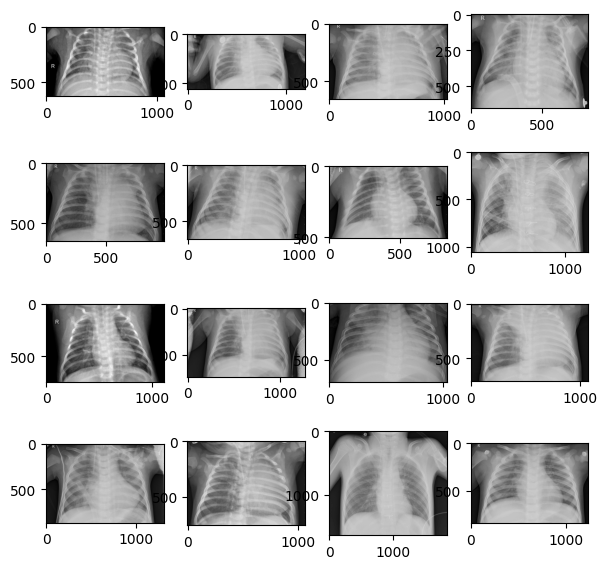

In [ ]:
# Create a list of file paths for pneumonia images
pneumonia_images = list(data_dir.glob('train/pneumonia/*'))
# Open and display the first pneumonia image in the list

for i in range(2, 18):
    plt.subplot(4, 4, i - 1)
    img = PIL.Image.open(str(pneumonia_images[i - 1]))
    plt.imshow(img,cmap = 'gray')
plt.show()

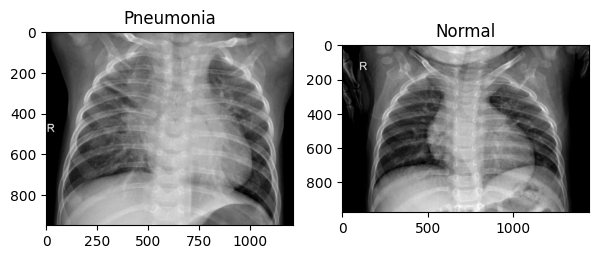

In [ ]:
# BEGIN YOUR CODE HERE

# 3. Display a pneumonia and a normal image from the testing dataset
# Create a list of file paths for pneumonia images
pneumonia_images = list(data_dir.glob('train/pneumonia/*'))
normal_images = list(data_dir.glob('train/normal/*'))
# Open and display the first pneumonia image in the list
plt.subplot(1,2,1)
plt.title('Pneumonia')
pimg = PIL.Image.open(str(pneumonia_images[0]))
plt.imshow(pimg,cmap='gray')
plt.subplot(1,2,2)
plt.title('Normal')
nimg = PIL.Image.open(str(normal_images[0]))
plt.imshow(nimg,cmap='gray')
plt.show()

# END YOUR CODE HERE

# Define a deep learning model that will learn the differences between pneumonia and normal CT images


In [ ]:
# Define batch size and image dimensions for training

# BEGIN YOUR CODE HERE
# The batch size is the number of samples processed before the model is updated.
# Choose an appropriate batch size. Find out the resolution of the image and
# fill in the values of the following three variables
# batch_size = TODO
# img_height = TODO
# img_width = TODO
batch_size = 8

#Fetch the image
img_count = 0
all_img_width = []
all_img_height= []
for pneumonia_image in pneumonia_images:
  image = PIL.Image.open(pneumonia_image)
#Get image dim
  img_width, img_height = image.size
  all_img_width.append(img_width)
  all_img_height.append(img_height)

img_height = min(all_img_height)
img_width = min(all_img_width)

img_height = 450
img_width = 450

#resizing images to averages

for pneumonia_image in pneumonia_images:
  image = PIL.Image.open(pneumonia_image)
  image = image.resize((img_height,img_width))
  image.save(pneumonia_image)
for normal_image in normal_images:
  image = PIL.Image.open(normal_image)
  image = image.resize((img_height,img_width))
  image.save(normal_image)

print(img_height)
print(img_width)
# END YOUR CODE HERE

450
450


In [ ]:
train_data_dir  = os.path.join(data_dir,'train')
test_data_dir = os.path.join(data_dir,'test')

In [ ]:
# Create a TensorFlow image dataset from a directory
# BEGIN YOUR CODE HERE
# Use the function tf.keras.utils.image_dataset_from_directory in order to load
# the training dataset: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# 1. First argument is your training directory folder,
# 2. Use 20% of the data for validation, for image size,
# 3. name the subset as "training"-
# 4. you can set a seed such that when you repeat experiments you get similar results, eg: seed=123
# 5. for image size use the img_height and img_width variables you defined previously.
# 6. Use for batch size the batch_size variable you defined earlier in the code
# tf.keras.utils.image_dataset_from_directory(
#     directory,
#     validation_split=None,
#     subset='',
#     seed=None,
#     image_size=(height, width),
#     batch_size=-1
# )
# eg: train_ds = tf.keras.utils.image_dataset_from_directory(...)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)


# END YOUR CODE HERE

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 450, 450, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Create a layer to normalise pixel values to the [0, 1] range.
# By default, when you load an image, each pixel value will have a value between 0-255
# but, in neural networks, we need as input normalised values in [0,1] interval.
normalization_layer = tf.keras.layers.Rescaling(1./255)

0.0 1.0 tf.Tensor([0.08627451 0.08627451 0.08627451], shape=(3,), dtype=float32)


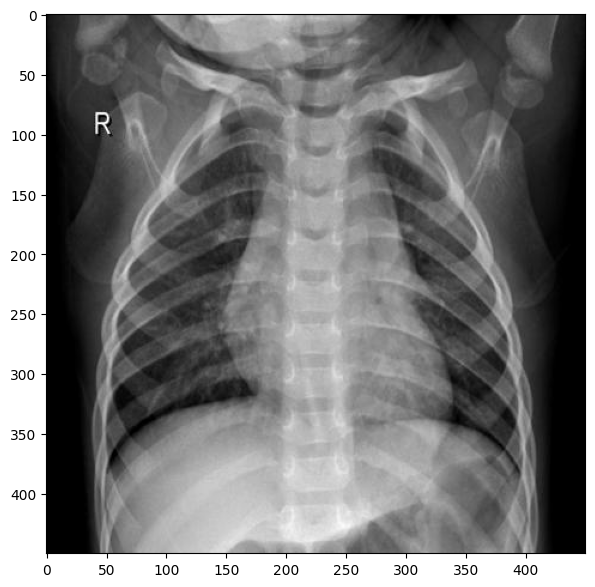

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image), first_image[0][0])
plt.imshow(image_batch[1])

In [ ]:
# BEGIN YOUR CODE HERE
# Define the number of classes in the classification problem.
# How many classes do we have in this dataset?
# num_classes = TODO

num_classes = 2 #Either have pneumonia or not

# END YOUR CODE HERE

In [ ]:
# BEGIN YOUR CODE HERE
# Define a tensorflow model using the tf.keras.Sequential class: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
# The last layer should be a Dense layer with the number of output neurons num_classes
# Use as a starting point the tf.keras.Sequential model defined for the MNIST problem.
# See Lab-DeepLearning-ImageClassification.
# For the first Conv2D layer, you are not required to specify the input shape. If that
# parameter is not given, tensorflow library will infer the size of the input when
# you fit the model, so it will depend on the size of the dataset.
# Important: change the output of the last Dense layer to match the number of classes for this problem.
# If you don't use any of the Dropout layers what accuracy do you get?
# What accuracy do you get with the Dropout layers?

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(2, activation='softmax')
])

# END YOUR CODE HERE

In [ ]:
# Compile the model with an optimizer, loss function, and evaluation metric
# There are several ways in which the loss or error between the label and
# the predictions can be computed. One of them is called SparseCategoricalCrossentropy
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
# You can also experiment with BinaryCrossentropy since for this problem we also have
# two classes, pneumonia vs normal: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']) # Monitor accuracy and F1 score during training

Epoch 1/5
20/20 [==============================] - 2s 38ms/step - loss: 2638.7192 - accuracy: 0.7750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
20/20 [==============================] - 1s 26ms/step - loss: 959.3636 - accuracy: 0.4750 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/5
20/20 [==============================] - 1s 26ms/step - loss: 4.4881 - accuracy: 0.5312 - val_loss: 1.3587 - val_accuracy: 0.7000
Epoch 4/5
20/20 [==============================] - 1s 26ms/step - loss: 0.3222 - accuracy: 0.8813 - val_loss: 1.0386 - val_accuracy: 0.7250
Epoch 5/5
20/20 [==============================] - 1s 26ms/step - loss: 0.1934 - accuracy: 0.9375 - val_loss: 1.0234 - val_accuracy: 0.7750


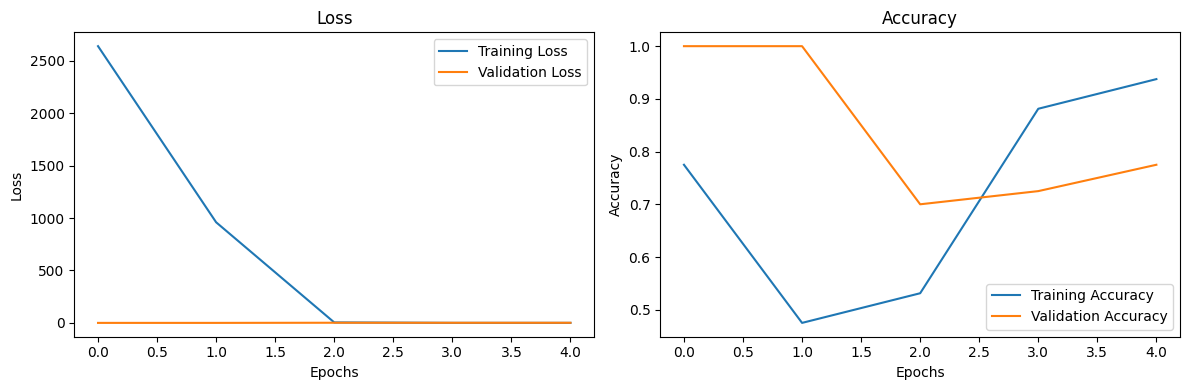

In [ ]:
# BEGIN YOUR CODE HERE
# Train the model on the provided dataset for a specified number of epochs
# Modify the network architecture such that you maximise the accuracy.
# Tip: aim to get an accuracy of at least 90% on the training set.
# For this, you can use the function fit, as in model.fit(...)
# The first argument is the train_ds variable defined above.
# This variable contains both the x (data - pneumonia and normal images) and y
# (labels - pneumonia vs normal).
# Start training using 5 epochs. What is the accuracy you get?
# How about if you increase the number of epochs?

# Train the model
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
    )

# Extract the training and validation loss and accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
# END YOUR CODE HERE

In [ ]:
# Let's load the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.


In [ ]:
#setting the input size of test images
test_images = list(data_dir.glob('test/*/*'))
for test_img in test_images:
  image = PIL.Image.open(test_img)
  image = image.resize((img_height,img_width))
  image.save(test_img)


In [ ]:
# BEGIN YOUR CODE HERE
# What is the loss and accuracy on the Testing dataset?
# Tip: instead of (x_test, y_test) we used in the lab last week, you can use
# directly test_ds which contains both data and labels
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
# eg: model.evaluate(...)
# You only need to specify the testing dataset.
history = model.evaluate(test_ds)

loss = history[0]
accuracy = history[1]


# END YOUR CODE HERE

13/13 [==============================] - 0s 14ms/step - loss: 1.0210 - accuracy: 0.7900
